# <center>Binary semantic segmentation with U-Net</center>

<b>Updated: May 3, 2023</b>

<div class="alert alert-block alert-info">
<b>To do:</b>
    
- Improve the model performance
    
- Add notes and references 
</div>

---
<a id='section_t'></a>

<h2>Table of contents</h2>

- ### 0. [Notes](#section_0)


- ### 1. [Import libraries and datasets](#section_1) 


- ### 2. [Define image generator](#section_2)


- ### 3. [U-Net modeling](#section_3)

---
<a id='section_0'></a>

# 0. Notes

Back to [Table of contents](#section_t)

- ## References
    - #### [Introductory Python Tutorial for Image Processing by APEER](https://github.com/bnsreenu/python_for_image_processing_APEER) 

    - #### [U-Net Image Segmentation in Keras by pyimagesearch](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)

- ## U-Net model architecture

#### <center>Figure from [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)</center>

![U-net model](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


---
<a id='section_1'></a>
# 1. Import libraries and datasets

Back to [Table of contents](#section_t)

### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob 
import json
import random

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### for utils
import inspect
#import utils

#### tensorflow
import tensorflow as tf

#### Keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.utils import normalize
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose,BatchNormalization, Dropout, Lambda
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

### GPU

In [12]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Allow memory growth for all available GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         # Restrict TensorFlow to use only the first GPU
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     except RuntimeError as e:
#         # Visible devices must be set at program startup
#         print(e)

### Randominess seed

In [3]:
SEED = 42

### Util functions

In [4]:
def panel_multiple_pairs(pairs, raw_path, labeled_path, title):
    '''
    Panel plot of multiple paired images 
    
    Parameters
    -----------
    pairs: list of tuples
        each tuple contains the paired file names
        example: [('173.jpg', '173.png'),
                  ('385.jpg', '385.png'),
                  ('460.jpg', '460.png'),
                  ('018.jpg', '018.png'),
                  ('430.jpg', '430.png')]
    
    raw_path: string
        folder path of original images
    
    labeled_path: string
        folder path of labeled images
    
    title: string
        suptitle of the panel plot
    
    Returns
    -----------
    Panel plot
    '''
    
    fig, axs = plt.subplots(len(pairs), 2, figsize=(10, 20))
    
    for i, (raw_file, labeled_file) in enumerate(pairs):
        raw_image = Image.open(os.path.join(raw_path, raw_file))
        labeled_image = Image.open(os.path.join(labeled_path, labeled_file))
        
        axs[i, 0].imshow(raw_image)
        axs[i, 0].set_title('Original Image ('+raw_file+')')
        
        axs[i, 1].imshow(labeled_image)
        axs[i, 1].set_title('Labeled Image ('+labeled_file+')')
        
    plt.suptitle(title, y = 0.9, fontsize=20, fontweight='bold')
    plt.show()

def width_height_aspect(path, files):
    '''
    Extract the width, height, and aspect ratio of the image dataset

    Parameters
    ----------
    path: string
        folder path where the files live

    files: list of strings
        file names of the images

    Returns
    ----------
    width: list of numerical values

    height: list of numerical values

    aspect: list of numerical values

    '''

    width, height, aspect = [], [], []

    for file in files:
        img = Image.open(path + file)

        temp_width, temp_height = img.size
        temp_aspect = temp_width / temp_height

        width.append(temp_width)
        height.append(temp_height)
        aspect.append(temp_aspect)

    return width, height, aspect

### Dataset directories

In [ ]:
# base_path = os.getcwd()

# train_image_path = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/train_images/')
# train_mask_path  = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/train_masks/')

# val_image_path = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/val_images/')
# val_mask_path  = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/val_masks/')

# test_image_path = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/test_images/')
# test_mask_path  = os.path.join(base_path, 'semantic_drone_dataset_kaggle/binary_dataset_split/test_masks/')

In [5]:
# In Google Colab

train_image_path = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/train_images/'
train_mask_path  = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/train_masks/'

val_image_path = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/val_images/'
val_mask_path  = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/val_masks/'

test_image_path = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/test_images/'
test_mask_path  = '/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/semantic_drone_dataset_kaggle/binary_dataset_split/test_masks/'


### Get image and mask list and sort the files

<div class="alert alert-block alert-danger">
<b>Note: very important to sort the files so we match images and masks with same number.</b>
</div>

In [6]:
train_image_list = os.listdir(train_image_path+'train/')
train_image_list.sort()

train_mask_list = os.listdir(train_mask_path+'train/')
train_mask_list.sort()

### Print the number of training images, validation images, and test images

In [7]:
print("Total number of training images: ", len(os.listdir(train_image_path+'train/')))
print("Total number of validation images: ", len(os.listdir(val_image_path+'val/')))
print("Total number of test images: ", len(os.listdir(test_image_path+'test/')))

Total number of training images:  320
Total number of validation images:  40
Total number of test images:  40


### Binary class and colormap

<div class="alert alert-block alert-info">
<b>Our original mask files are in RGB value, we will convert the mask pixels to 0 and 1 later. Here, we print out the RGB values of `obstacles` (i.e., objects) and `landing-zones` (i.e., background).</b>
</div>

In [8]:
mask_dict = json.load(open('/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/data/DICT_kaggle_binary_CLASSES_COLORS.txt'))
mask_class = mask_dict.keys()
mask_colormap = mask_dict.values()

In [9]:
print('Binary mask classes:', mask_class)
print('Binary mask colormaps:', mask_colormap)

Binary mask classes: dict_keys(['obstacles', 'landing-zones'])
Binary mask colormaps: dict_values([[204, 153, 255], [0, 153, 153]])


### Sanity check 

<div class="alert alert-block alert-info">
<b>It's always a good practice to do sanity check during image segmentation projects, to make sure the image files and mask files are aligned with each other.</b>
</div>

In [10]:
print(inspect.getdoc(panel_multiple_pairs))

Panel plot of multiple paired images 

Parameters
-----------
pairs: list of tuples
    each tuple contains the paired file names
    example: [('173.jpg', '173.png'),
              ('385.jpg', '385.png'),
              ('460.jpg', '460.png'),
              ('018.jpg', '018.png'),
              ('430.jpg', '430.png')]

raw_path: string
    folder path of original images

labeled_path: string
    folder path of labeled images

title: string
    suptitle of the panel plot

Returns
-----------
Panel plot


In [11]:
random_pairs = random.sample(list(zip(train_image_list,train_mask_list)), 5)
random_pairs

[('488.png', '488.png'),
 ('195.png', '195.png'),
 ('306.png', '306.png'),
 ('326.png', '326.png'),
 ('190.png', '190.png')]

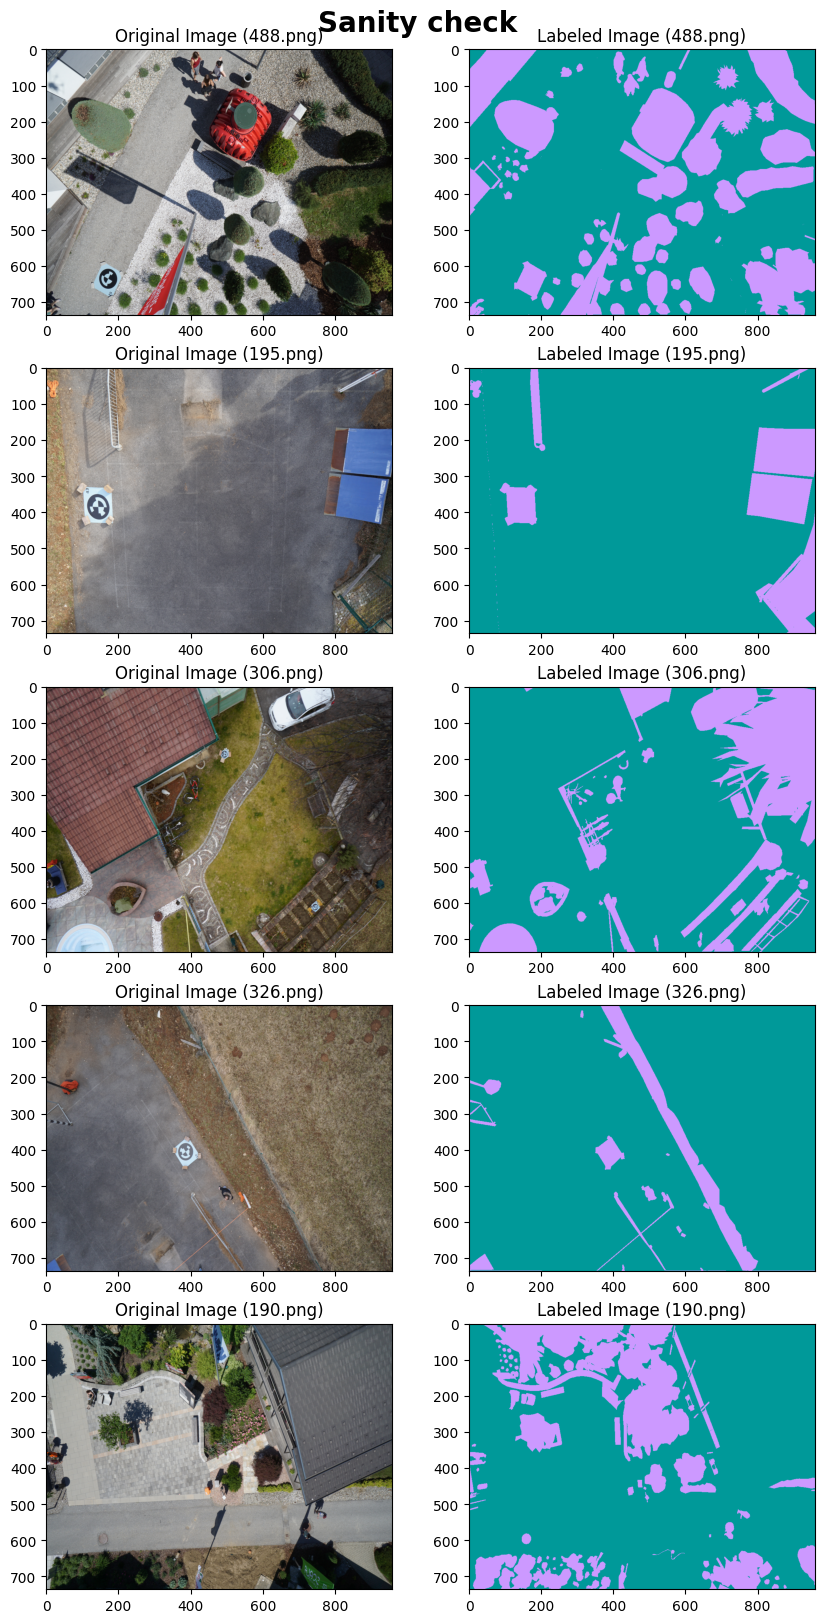

In [12]:
panel_multiple_pairs(random_pairs, train_image_path+'train/', train_mask_path+'train/', 'Sanity check')

### Define a preprocessing function 

<div class="alert alert-block alert-info">
<b>Preprocessing:</b>
    
We will embed the preprocessing function within the image generator (defined later), so that every time we get batched pairs of images and masks, we first preprocessing the arrays and then feed into the model. 
    
We define the preprocessing function here to do sanity check, making sure we are handling this properly.
    
<b>Note that we only do the scaling and mask value conversion in this preprocessing function. We will adopt TensorFlow's built-in resize method to resize the files (see details in the image generator function).</b>

</div>

In [13]:
def preprocess_data(image, mask):
    '''
    Preprocessing of image and mask files, including:
        - scaling the image RGB values 
        - converting mask pixels to 0 and 1
    
    Parameters 
    ------------
    image: numpy array 
        if it is a single image, the array shape is likely [*image_size, channels]
        if it is batch files, the array shape is likely [batch_size, *image_size, channels]
    
    mask: numpy array
    
    Returns
    ------------
    Processed image and mask files
    
    '''
    
    ##### Step 1: Scale images
    image = image / 255.
    
    ###### Step 2: Convert mask RGB to binary values 0 and 1
    
    # object and background RGBs
    object_RGB = [204, 153, 255]
    background_RGB = [0, 153, 153]
    
    # create mask arrays
    mask_0= np.all(mask == background_RGB, axis=-1)
    mask_1= np.all(mask == object_RGB, axis=-1)
    
    mask_labels = np.zeros_like(mask_0)
    mask_labels[mask_0] = 0
    mask_labels[mask_1] = 1
    
    # convert the boolean array to integer array
    mask_binary = mask_labels.astype('int')
    
    # expand the last dimension 
    mask_binary = np.expand_dims(mask_binary, axis = len(mask_binary.shape))
    
    ##### Step 3: Return the preprocessed files
    return (image, mask_binary)

### Sanity check that the preprocessing function works properly

<div class="alert alert-block alert-danger">
<b>Note: don't forget to conver BGR to RGB when using open-cv</b>
</div>

In [14]:
# Load the image with OpenCV
image_to_process = cv2.imread(train_image_path+'train/'+train_image_list[0]) 
mask_to_process = cv2.imread(train_mask_path+'train/'+train_mask_list[0])

# Convert the image from BGR to RGB
image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2RGB)
mask_to_process = cv2.cvtColor(mask_to_process, cv2.COLOR_BGR2RGB)

# Convert to a NumPy array 
image_to_process_array = np.array(image_to_process)
mask_to_process_array = np.array(mask_to_process)

image_processed_array, mask_processed_array = preprocess_data(image_to_process_array, mask_to_process_array)

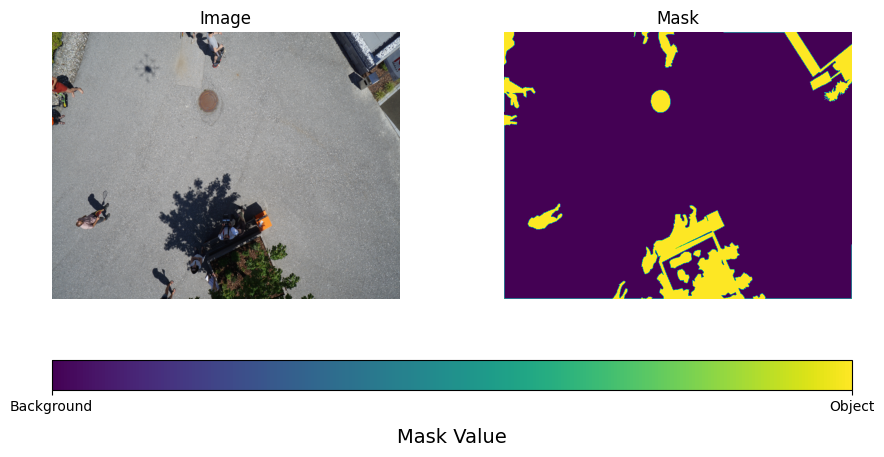

In [17]:
# create a panel with 3 rows and 2 columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))

ax[0].imshow(image_processed_array)
ax[0].set_title('Image')
ax[0].axis('off')

im = ax[1].imshow(mask_processed_array, cmap='viridis', vmin=0, vmax=1)
ax[1].set_title('Mask')
ax[1].axis('off')

# create a color bar for the mask images
cbar_ax = fig.add_axes([0.1, 0.35, 0.8, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 1], orientation='horizontal')
cbar.set_ticklabels(['Background', 'Object'])
cbar.set_label('Mask Value', fontsize=14, labelpad=10)

# adjust the spacing between the figures
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

# set the size of the mask image axis to match the original image axis
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlim(ax[0].get_xlim())
    
# show the figure
plt.show()

In [18]:
print('Minimum value of the image file: ', image_processed_array.min())
print('Maximum value of the image file: ', image_processed_array.max())
print('Minimum value of the mask file: ', mask_processed_array.min())
print('Maximum value of the mask file: ', mask_processed_array.max())
print('Unique value of the mask file: ', np.unique(mask_processed_array))

Minimum value of the image file:  0.00392156862745098
Maximum value of the image file:  1.0
Minimum value of the mask file:  0
Maximum value of the mask file:  1
Unique value of the mask file:  [0 1]


<div class="alert alert-block alert-success">

As shown above, our preprocessing function works properly. The post processed image array is in range between 0 and 1, and the mask file is converted to 0 and 1. 

</div>

---
<a id='section_2'></a>

# 2. Define Image Generator 
Back to [Table of contents](#section_t)

<div class="alert alert-block alert-info">

<b>Goal:</b>
Define generator for images and masks so we can read them directly from the drive

<b>Note: </b>
- We are not doing any rotation or zoom to make sure mask values are not interpolated.

- We do resize the image and mask files with proper interpolation methods.
    
- We embed the image scaling and mask RGB to binary conversion preprocessing in the generator function.

</div>

### Set parameters

In [19]:
seed = SEED
batch_size = 16
rescale_factor = 0.5
num_class  =1

### Height and width

<div class="alert alert-block alert-danger">

<b>Note on the order of image size:</b>

- You can extract the size information either by using OpenCV or using Pillow (PIL), but note that the order of width and height differ. See [this reference](https://note.nkmk.me/en/python-opencv-pillow-image-size/).
    
- In the example shown below, we used PIL size method in the utils.width_height_aspect function, where the size method returns a (width, height) tuple.
    
- The typical axis order for an image tensor in Tensorflow is as follows:
    
     shape=(N, H, W, C), where
    
     N - batch size (number of images per batch)
    
     H - height of the image
    
     W - width of the image
    
     C - number of channels (usually uses 3 channels for RGB)
</div>

In [20]:
print(inspect.getdoc(width_height_aspect))

Extract the width, height, and aspect ratio of the image dataset

Parameters
----------
path: string
    folder path where the files live

files: list of strings
    file names of the images

Returns
----------
width: list of numerical values

height: list of numerical values

aspect: list of numerical values


In [22]:
width, height, aspect = width_height_aspect(train_image_path + 'train/', train_image_list)

In [23]:
HEIGHT, WIDTH = set(height).pop(), set(width).pop()
HEIGHT, WIDTH

(736, 960)

### Define trainGenerator


<div class="alert alert-block alert-info">

<b>[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)</b>
    
- `flow_from_directory` returns: A DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels. 

<b>class_mode = None</b>
  
- Setting class_mode to None for both the image_generator and mask_generator means that the generators will not return any labels for the images and masks, respectively. This is useful if you are training a model for image segmentation, where the input is an image and the output is the corresponding mask. In this case, you do not need to provide labels for the images and masks separately, as the masks are the labels for the images. Instead, you can use the zip function to combine the image and mask generators and provide the output masks as labels for the image data during training.
    
<b>target_size=None</b>
    
- Images and masks will be generated at their original size. 
    

<b>tf.image.ResizeMethod.BILINEAR</b>
    
- Suitable for resizing color images.
    
<b>tf.image.ResizeMethod.NEAREST_NEIGHBOR</b>

- This is appropriate for binary masks. 
    
</div>

In [24]:
def dataGenerator(train_image_path, train_mask_path, num_class):
    
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_image_path,
        class_mode = None,
        color_mode = 'rgb',
        target_size= (HEIGHT, WIDTH),
        batch_size = batch_size,
        seed = SEED)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'rgb',
        target_size= (HEIGHT, WIDTH),
        batch_size = batch_size,
        seed = SEED)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (image, mask) in train_generator:
        # resize the image and mask using tf.image.resize()
        image_shape = image.shape
        target_height = int(image_shape[1] * rescale_factor)
        target_width = int(image_shape[2] * rescale_factor)
        
        resized_image = tf.image.resize_with_pad(image, target_height, target_width, \
                                                 method=tf.image.ResizeMethod.BILINEAR)
        
        resized_mask = tf.image.resize_with_pad(mask, target_height, target_width, \
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        image, mask = preprocess_data(resized_image, resized_mask)
        yield (image, mask)
        
    

In [25]:
train_data_gen = dataGenerator(train_image_path, train_mask_path, num_class=num_class)
val_data_gen = dataGenerator(val_image_path, val_mask_path, num_class=num_class)

- ### Sanity check

In [26]:
x_train, y_train = train_data_gen.__next__()

Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


In [27]:
print(x_train.shape)
print(y_train.shape)

(16, 368, 480, 3)
(16, 368, 480, 1)


In [28]:
print("max value in image dataset is: ", np.max(x_train))
print("min value in image dataset is: ", np.min(x_train))

print("max value in mask dataset is: ", np.max(y_train))
print("min value in mask dataset is: ", np.min(y_train))

max value in image dataset is:  1.0
min value in image dataset is:  0.0
max value in mask dataset is:  1
min value in mask dataset is:  0


#### Sanity check that background is 0, and object is 1

In [29]:
random_pairs

[('488.png', '488.png'),
 ('195.png', '195.png'),
 ('306.png', '306.png'),
 ('326.png', '326.png'),
 ('190.png', '190.png')]

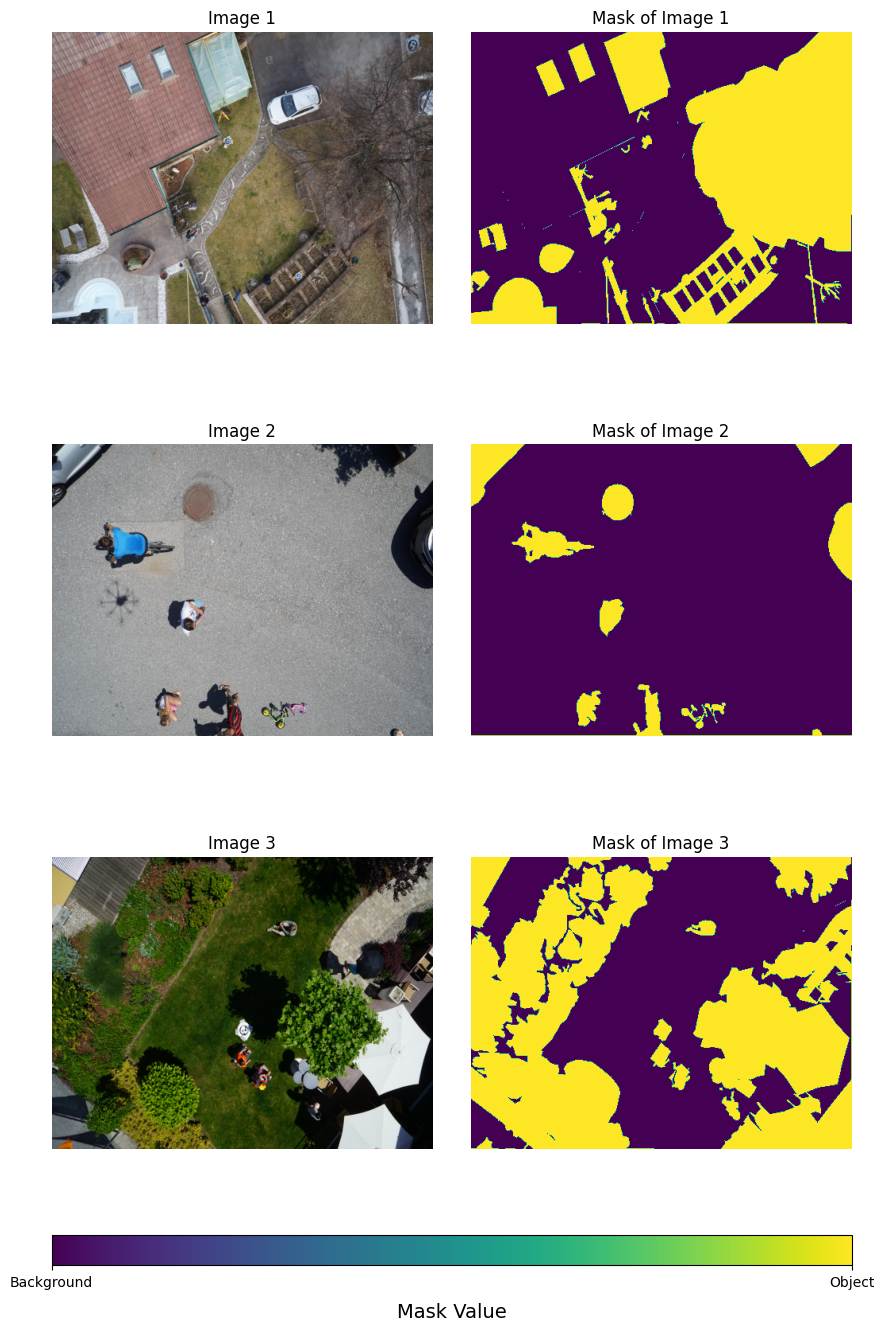

In [30]:
# create a panel with 3 rows and 2 columns
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# set the titles for the figures
titles = ['Image 1', 'Image 2', 'Image 3']

# loop through each row and column
for i in range(3):
    # plot the original image on the left column
    ax[i, 0].imshow(x_train[i, :, :, :])
    ax[i, 0].set_title(titles[i])
    ax[i, 0].axis('off')
    
    # plot the mask image on the right column
    im = ax[i, 1].imshow(y_train[i, :, :, :], cmap='viridis', vmin=0, vmax=1)
    ax[i, 1].set_title('Mask of ' + titles[i])
    ax[i, 1].axis('off')
    
# create a color bar for the mask images
# create a color bar for the mask images
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 1], orientation='horizontal')
cbar.set_ticklabels(['Background', 'Object'])
cbar.set_label('Mask Value', fontsize=14, labelpad=10)

# adjust the spacing between the figures
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# set the size of the mask image axis to match the original image axis
for i in range(3):
    ax[i, 1].set_ylim(ax[i, 0].get_ylim())
    ax[i, 1].set_xlim(ax[i, 0].get_xlim())
    
# show the figure
plt.show()

---
<a id='section_3'></a>
# 3. U-Net modeling
Back to [Table of contents](#section_t)


In [31]:
num_train_images = len(os.listdir(train_image_path+'train'))
num_val_images = len(os.listdir(val_image_path+'val'))

train_steps_per_epoch = num_train_images // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [34]:
##### U-Net
'''
U-Net model with Keras
 
Followed https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial121b_loading_data_from_drive_in_batches_for_unet_training.ipynb
'''
 
 # Building Unet by dividing encoder and decoder into blocks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
 
def conv_block(input, num_filters):
   x = Conv2D(num_filters, 3, padding="same")(input)
   x = BatchNormalization()(x)   #Not in the original network. 
   x = Activation("relu")(x)
 
   x = Conv2D(num_filters, 3, padding="same")(x)
   x = BatchNormalization()(x)  #Not in the original network
   x = Activation("relu")(x)
   return x
 
#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
   x = conv_block(input, num_filters)
   p = MaxPool2D((2, 2))(x)
   return x, p
 
#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
   x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
   x = Concatenate()([x, skip_features])
   x = conv_block(x, num_filters)
   return x

#Build Unet using the blocks
def keras_unet(input_shape, n_classes):
   inputs = Input(input_shape)
   s1, p1 = encoder_block(inputs, 64)
   s2, p2 = encoder_block(p1, 128)
   s3, p3 = encoder_block(p2, 256)
   s4, p4 = encoder_block(p3, 512)
 
   b1 = conv_block(p4, 1024) #Bridge
  
   d1 = decoder_block(b1, s4, 512)
   d2 = decoder_block(d1, s3, 256)
   d3 = decoder_block(d2, s2, 128)
   d4 = decoder_block(d3, s1, 64)
 
   if n_classes == 1:  #Binary
     activation = 'sigmoid'
   else:
     activation = 'softmax'

   outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
   print(activation)

   model = Model(inputs, outputs, name="U-Net")
   return model

In [35]:
model = keras_unet(input_shape, n_classes=num_class)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 368, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 368, 480, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 368, 480, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [36]:
history = model.fit(train_data_gen,
                   steps_per_epoch=train_steps_per_epoch,
                   epochs=50,
                   verbose=1,
                   validation_data=val_data_gen,
                   validation_steps=val_steps_per_epoch)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7636 Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
20/20 [==============================] - 345s 16s/step - loss: 0.5128 - accuracy: 0.7636 - val_loss: 416.1677 - val_accuracy: 0.2384
Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 0.3944 - accuracy: 0.8214 - val_loss: 422.4592 - val_accuracy: 0.2341
Epoch 3/50
20/20 [==============================] - 24s 1s/step - loss: 0.3982 - accuracy: 0.8147 - val_loss: 211.3791 - val_accuracy: 0.2328
Epoch 4/50
20/20 [==============================] - 24s 1s/step - loss: 0.3833 - accuracy: 0.8251 - val_loss: 19.1479 - val_accuracy: 0.2378
Epoch 5/50
20/20 [==============================] - 24s 1s/step - loss: 0.3836 - accuracy: 0.8257 - val_loss: 80.2758 - val_accuracy: 0.2195
Epoch 6/50
20/20 [==============================] - 24s 1s/step - loss: 0.3732 - accuracy: 0.8306 - val_loss: 0.7747 - val_accu

In [37]:
model.save('/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/models/binary_keras_unet_v2.hdf5')

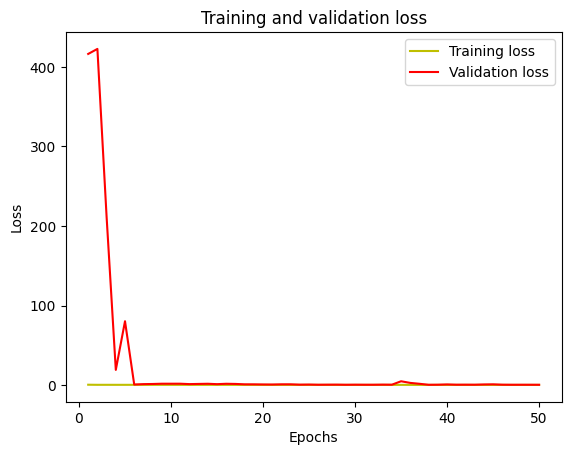

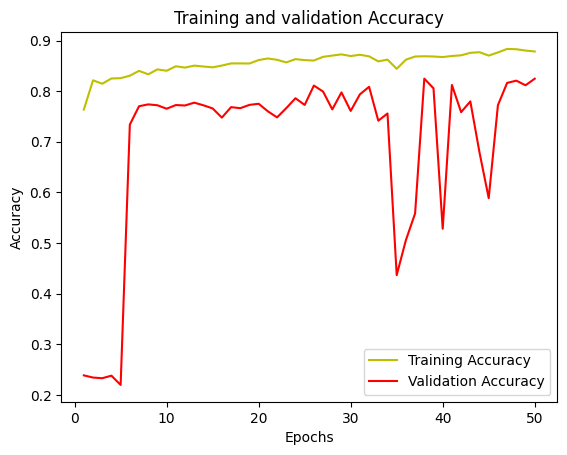

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
from keras.models import load_model 

model = load_model('/content/drive/MyDrive/Colab Notebooks/Drone_image_segmentation/models/binary_keras_unet_v2.hdf5', compile=False)

In [40]:
test_data_gen = dataGenerator(test_image_path, test_mask_path, num_class=num_class)

In [41]:
test_image_batch, test_mask_batch = test_data_gen.__next__()

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


In [42]:
y_pred = model.predict(test_image_batch)

1/1 [==============================] - 0s 440ms/step


In [44]:
y_true = test_mask_batch


In [45]:
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_true, y_pred, sample_weight=None)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.41952717


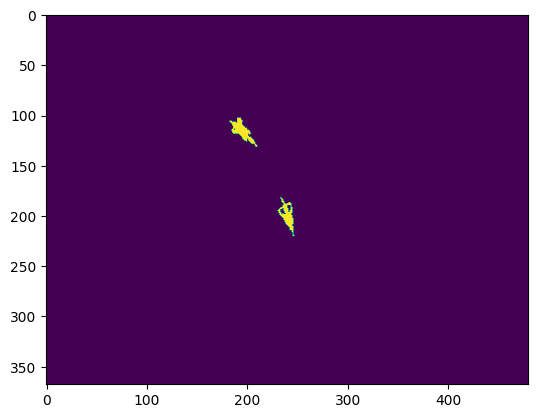

In [46]:
plt.imshow(y_true[0])

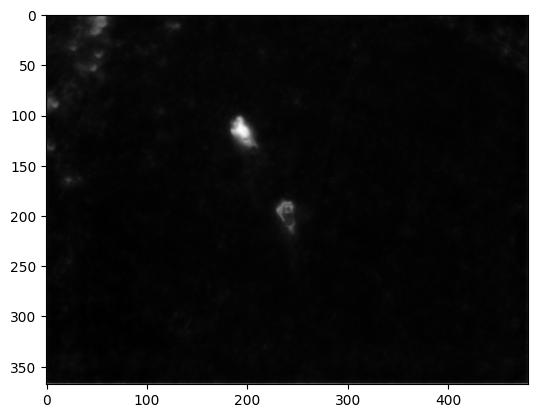

In [47]:
plt.imshow(y_pred[0], cmap='gray')

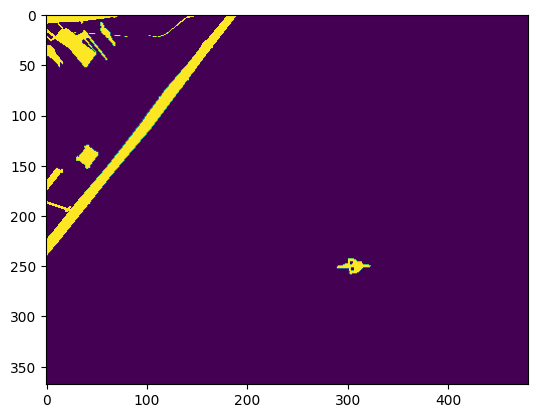

In [48]:
plt.imshow(y_true[10])

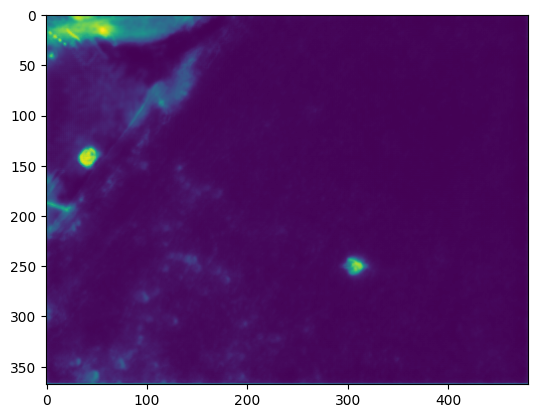

In [49]:
plt.imshow(y_pred[10])